In [11]:
import pickle
import gzip
import numpy as np
import os

In [12]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

## Preprocessing

In [13]:
data = load_zipped_pickle("./data/train.pkl")

In [34]:
import numpy as np
import cv2
import gzip
import pickle
from sklearn.model_selection import train_test_split
from skimage import filters

def pad_to_aspect_ratio(image, target_aspect_ratio):
    # Compute the new dimensions while maintaining the aspect ratio
    h, w = image.shape[:2]
    target_h, target_w = target_aspect_ratio
    scale = min(target_h / h, target_w / w)
    new_h, new_w = int(h * scale), int(w * scale)
    image_resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Pad to the target size
    delta_h, delta_w = target_h - new_h, target_w - new_w
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    image_padded = cv2.copyMakeBorder(image_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

    return image_padded

def preprocess_data(data, target_size=(256, 256)):
    preprocessed_data = []

    for entry in data:
        new_entry = entry.copy()  # Copy the original entry structure
        video_frames = entry['video']
        labels = entry['label']
        labeled_frames_indices = entry['frames']

        # Initialize new video and labels lists
        new_video_frames = np.empty((*target_size, len(labeled_frames_indices)), dtype=np.float32)
        new_labels = np.empty((*target_size, len(labeled_frames_indices)), dtype=bool)

        for i, frame_index in enumerate(labeled_frames_indices):
            # Process the frame and label, keeping aspect ratio
            frame = video_frames[:, :, frame_index]
            label = labels[:, :, frame_index].astype(np.uint8)  # Ensure label is integer type before processing
            
            processed_frame = pad_to_aspect_ratio(frame, target_size)
            processed_label = pad_to_aspect_ratio(label, target_size)

            # Apply denoising to the frame (You can add denoising here)
            denoised_frame = cv2.fastNlMeansDenoising(processed_frame, None, 5, 5, 10)

            # Apply CLAHE to the frame
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            processed_frame = clahe.apply(denoised_frame)

            # Normalize the frame
            processed_frame = processed_frame / 255.0

            # Store processed frame and label
            new_video_frames[:, :, i] = processed_frame
            new_labels[:, :, i] = processed_label.astype(bool)  # Convert back to boolean type

        # Update the new entry with processed video frames and labels
        new_entry['video'] = new_video_frames
        new_entry['label'] = new_labels

        preprocessed_data.append(new_entry)

    return preprocessed_data


# Load and preprocess the dataset
processed_data = preprocess_data(data)


In [42]:
save_zipped_pickle(processed_data, "./data/train_processed.pkl")

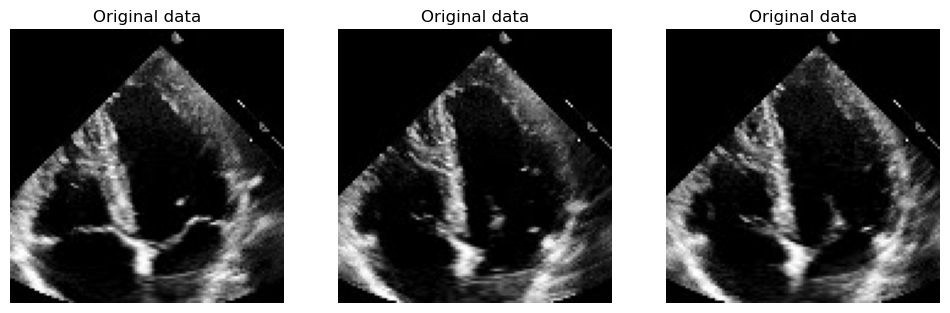

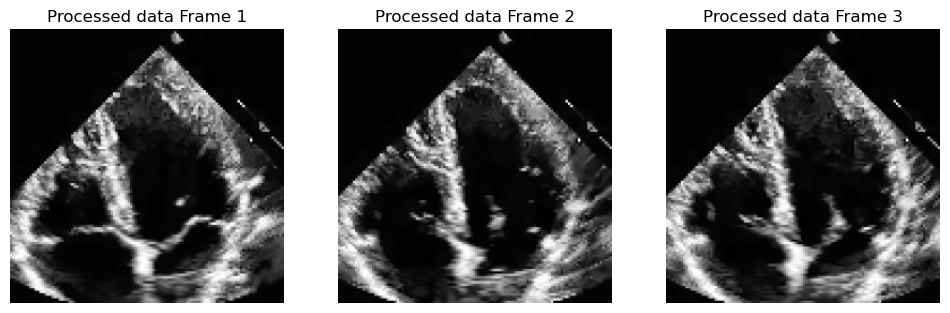

In [35]:
import random
import matplotlib.pyplot as plt



def plot_original_frames(data, title=None):
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))

    # Plot the frames with labels of the first video in the data
    video_frames = data[0]['video']
    labels = data[0]['label']
    labeled_frames_indices = data[0]['frames']

    for i, frame_index in enumerate(labeled_frames_indices):
        frame = video_frames[:, :, frame_index]  # Get the frame with label
        label = labels[:, :, frame_index]  # Get the corresponding label

        axs[i].imshow(frame, cmap='gray')
        #axs[i].imshow(label, cmap='jet', alpha=0.5)  # Overlay label on frame
        axs[i].axis('off')
        if title:
            axs[i].set_title(title)

    plt.show()


def plot_processed_frames(data, title=None):
    # Get the first video's frames
    video_frames = data[0]['video']
    num_frames = video_frames.shape[-1]

    # Create subplots
    fig, axs = plt.subplots(1, num_frames, figsize=(12, 6))

    # Plot all frames of the first video
    for i in range(num_frames):
        frame = video_frames[..., i]  # Get the i-th frame
        axs[i].imshow(frame, cmap='gray')
        axs[i].axis('off')
        if title:
            axs[i].set_title(f"{title} Frame {i+1}")

    plt.show()
# Plot frames for expert video
plot_original_frames(data, 'Original data')

# Plot frames for amateur video
plot_processed_frames(processed_data, 'Processed data')


## Model MaskDINO

In [37]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split



videos = [entry['video'] for entry in processed_data]
labels = [entry['label'] for entry in processed_data]

# Convert lists to numpy arrays and expand dimensions
X = np.array(videos)  # Shape: (num_samples, height, width, num_frames)
y = np.array(labels)  # Shape: (num_samples, height, width, num_frames)

# Flatten frames for individual training samples
X = X.reshape(-1, X.shape[1], X.shape[2], 1)  # Shape: (num_samples * num_frames, height, width, 1)
y = y.reshape(-1, y.shape[1], y.shape[2], 1)  # Shape: (num_samples * num_frames, height, width, 1)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Down-sampling
    # Define the down-sampling path consisting of Conv2D and MaxPooling2D layers
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Up-sampling
    # Define the up-sampling path consisting of UpSampling2D and Conv2D layers
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model



In [41]:
unet_model = unet()
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

history = unet_model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.1)

Epoch 1/100


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import jaccard_score

# Predict on test data
y_pred = unet_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(np.int32)  # Binarize predictions

# Calculate Jaccard Index (IoU) for each sample
ious = []
for y_true_sample, y_pred_sample in zip(y_test, y_pred):
    iou = jaccard_score(y_true_sample.flatten(), y_pred_sample.flatten())
    ious.append(iou)

median_iou = np.median(ious)
print("Median Jaccard Index (IoU) on Test Data:", median_iou)